In [1]:
%matplotlib notebook
import numpy as np
import os
from colicoords import iter_subplots, Data, CellListPlot, CellPlot, data_to_cells, filter_binaries
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from skimage.feature import peak_local_max

This notebook will go over how to find peaks (spots/foci) in fluorescence images, convert them to a STORM data element and add it to ``Cell`` objects and derive some plots / statistics from the data.

In [2]:
bf = tifffile.imread('brightfield.tif')
binary = tifffile.imread('binary.tif')
flu = tifffile.imread('fluorescence.tif')

<IPython.core.display.Javascript object>


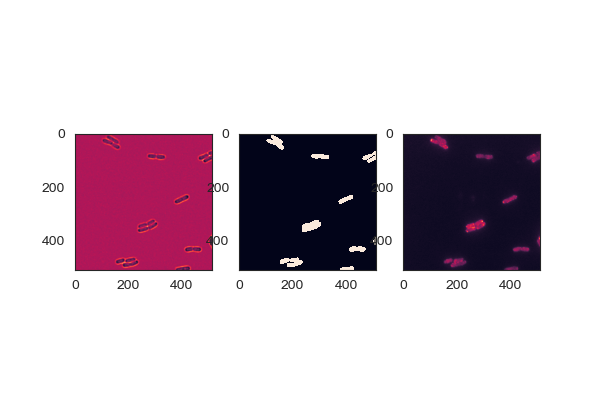

In [3]:
fig, axes = iter_subplots(1, 3, figsize=(6, 4))
axes[0].iter_imshow(bf)
axes[1].iter_imshow(binary, interpolation='none')
axes[2].iter_imshow(flu)
fig.display()

If you look closely at the fluorescence channel you can see that there cells have, apart from background cytosolic fluorescence, some distinct foci. We can use a spot finding algorithm to find them and add them to ``ColiCoords``. For this, ThunderSTORM or other super-resution software can be used, or I'll demonstrate here some rudimentary python implementation.

In [7]:
x_out = []
y_out = []
frame_out = []

for i, img in enumerate(flu):
    # First obtain the background by median filtering
    mf = medfilt(img, 5)  
    
    # Subtract this background
    img_bg = img - mf  
    
    #Find the peaks using some arbirarily chosen threshold
    peaks = peak_local_max(img_bg, min_distance=5, threshold_abs=1250)
    
    # Append x and y positions
    y, x = peaks.T
    x_out += list(x)
    y_out += list(y)
    
    # The frame number starts at one (which indicated in whichn images in the 
    # stack the spot is in)
    frame_out += [i+1]*len(x)

If you would take a look at the feak finding result you will find that its quite poor but this can be improved by tweaking parameters but the aim is here to demonstrate the proof of principle.

We'll now create a numpy recarray according to the STORM format:

In [8]:
storm_dtype = [('x', float), ('y', float), ('intensity', float), ('frame', int)]

storm = np.empty(len(x_out), dtype=storm_dtype)
storm['x'] = x_out
storm['y'] = y_out

storm['intensity'] = np.ones_like(x_out)
storm['frame'] = frame_out

The pixel locations are in whole pixel resolution. If you want sub-pixel resolution, you should either use ThunderSTORM or fit each peak to a gaussian for better accuracy. 
Fitting with a gaussian can also give you the intensity, which we dont have now so I've set everything to one.

In [11]:
# Filter the binaries so that they're labelled
bin_labeled = filter_binaries(binary)

data = Data()
data.add_data(bin_labeled, 'binary')
data.add_data(bf, 'brightfield')
data.add_data(flu, 'fluorescence')
data.add_data(storm, 'storm')

The ``storm`` datasets can be added as a regular data element, and using ``data_to_cells`` will ensure that the localizations are assinged to each cell object.

In [12]:
cells = data_to_cells(data)

Cell 4 on image binary 1: on the edge of the image


<IPython.core.display.Javascript object>


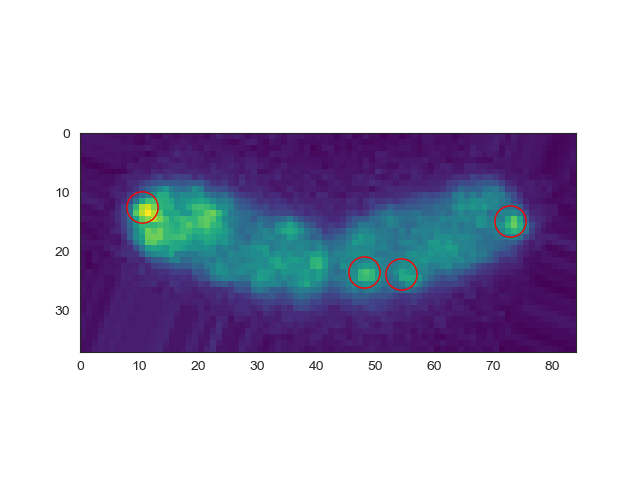

In [23]:
cp = CellPlot(cells[3])
plt.figure()
cp.imshow('fluorescence')
cp.plot_storm(fillstyle='none', markersize=45)

Again, proof of concept. Lets see what the longitinudial and radial distribution of the spot positions look like, as well as the number of spots per cell. 

<IPython.core.display.Javascript object>


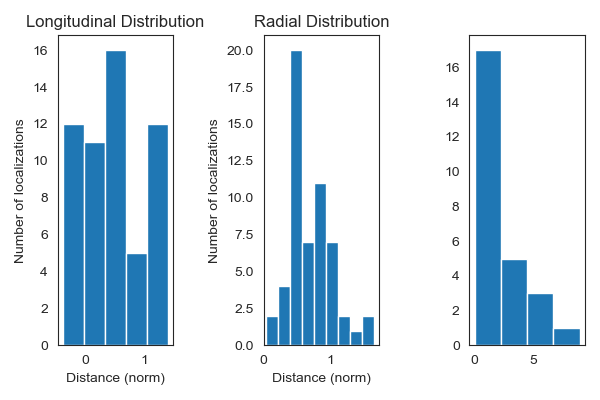

In [25]:
clp = CellListPlot(cells)
fig, axes = plt.subplots(1, 3, figsize=(6, 4))
clp.hist_l_storm(ax=axes[0])
clp.hist_r_storm(ax=axes[1])
num = [len(cell.data.data_dict['storm']) for cell in cells]
axes[2].hist(num, bins='fd')
plt.tight_layout()

From this we can see that the spots are uniformly distributed along the long axis, and peripherally distributed along the short axis. 

Note that we didnt optimize any coordinate system or removed clusters of cells so the results are fairly inaccurate.